In [1]:
# Copyright 2018 Anar Amirli
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Model Testing

In this document, we test our Random Forest for classifying the ball state (wheter game is stoped or not) and the ball coordinate on the y-axis:

1. We have sufficiently enough training data, therefore we're not going to apply K-fold cross-validation on our model.

In [15]:
%matplotlib  inline

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
import itertools

# our common utility functions that are used in different notebooks
from utils import *

In [3]:
def describe_dataset(y_val): 
    heading = 'Pitch index counts'
    print(heading + '\n' + '-'*len(heading))
    for key, val in sorted(Counter(y_val).items()):
        print('{}\t: {}'.format(int(key), val))

## Labale and Columns Names

In [5]:
all_data = pd.read_csv('data_all_2.csv')

In [6]:
classes = ['Null', 'Game Play']

feature_names = list(all_data.columns[:-4])

## Cross Validation for Classifier

In [7]:
def random_forest_cv(clf, X, y, feature_names, classes=None, k=10):
    label_ids = sorted(np.unique(y), key=abs)
    
    # shuffle the data
    X, y = shuffle(X, y)
    
    # get K folds
    skf = KFold(n_splits=k, shuffle=True)
    skf.get_n_splits(X, y)
    
    # cumulative confusion matrix and feature importance arrays
    conf_mat = np.zeros((len(label_ids), len(label_ids)))
    feature_importances = np.zeros(X.shape[1])
    
    # for each fold in KFold
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # fit with current train set
        clf = clf.fit(X_train, y_train)
        # predict the current test set
        y_pred = clf.predict(X_test)
        
        # keep cumulative sum of conf_mat and feature_importances
        conf_mat += confusion_matrix(y_test, y_pred, labels=label_ids)
        feature_importances += clf.feature_importances_
     
    # normalize importances
    feature_importances /= k
    
    if classes is None:
        classes = label_ids
    
    # plot
    plot_confusion_matrix(conf_mat, classes, 'Prediction', 'Truth', normalize=True)
    plot_hbar_nameval(feature_names, feature_importances, 'Feature importances', max_bars=20)
    
    all_pred=0.0
    true_pred=0.0
    for i in range(len(feature_names)):
        for j in range(len(feature_names)):
            all_pred+=cm[i][j]
            if i==j:
                true_pred+=cm[i][j]
                
    true_pred /= all_pred
    
    return true_pred, conf_mat, feature_importances

## SMOTE
SMOTE (Synthetic Minority Over-Sampling Technique) is an over-sampling technique that introduces small perturbations to synthetic examples along the direction of existing samples to reduce overfitting. See original paper for detailed explanation of SMOTE.
## SMOTE Implementation
There is a SMOTE implementation in imblearn package for scikit-learn. However, there is not an option to apply SMOTE with arbitrary percentages (SMOTE-100, SMOTE-300, etc.); it simply balances all the classes. And also since SMOTE is not a hard to implement algorithm, we provide our own implementation. Our dataset sizes are not big (order of 10k). Hence, a simple Python implementation would be more than sufficien for our needs. See the original paper for reference algorithm.

In [8]:
from sklearn.neighbors import NearestNeighbors
from random import randint


def smote(samples, amount, k=5):
    """
    Apply SMOTE algorithm to samples and return a new samples
    array with synthetically created samples.
    
    Parameters
    ----------
    samples: (n_samples, n_features) samples array to be sent to
             SMOTE algorithm.
    amount: Percentage of newly created synthetic samples. (E.g.
            amount=100 would create as many synthetic examples
            as existing ones).
    k: Number of nearest neighbors in SMOTE algorithm.
    
    Returns
    -------
    out: ((1 + amount/100)*n_samples, n_features) samples array containing
         the original and the newly created synthetic examples.
         
    References
    ----------
    http://www.jair.org/media/953/live-953-2037-jair.pdf
    """
    samples = np.copy(samples)
    n_samples, n_features = samples.shape
    # handle amount < 100 case
    if amount < 100:
        num_samples = int(len(samples)*(amount/100))
        np.shuffle(samples)
        samples = samples[:num_samples, :]
        amount = 100
    amount = int(amount/100)
    synthetic = np.empty((n_samples*amount, n_features))
    # find k nearest neighbors of each point and store it in nnarray
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(samples)
    _, nnarray = nbrs.kneighbors(samples)
    nnarray = nnarray[:, 1:]  # get rid of self-nearest-neighbor.
    # create synthetic examples and store them in synthetic.
    for i, neighbors in enumerate(nnarray):
        for j in range(amount):
            chosen = neighbors[randint(0, k - 1)]
            diff = samples[chosen] - samples[i]
            gap = np.random.rand(n_features)
            synthetic[i*amount + j] = samples[i] + gap*diff
    out = np.vstack((samples, synthetic))
    
    return out

## SMOTE for  data

Assigment number of corner segments in our dataset is much fewer than other segments. We use SMOTE algorithm with various synthetic example amounts to generate more examples for this segments.

We can't use nominal features in our current SMOTE implementation

TODO: Implement SMOTE-NC

In [9]:
from sklearn.utils import shuffle

def smote_sampling(X, y, pitch_segment):
    smote_amount = 100
    pitch_segment_mask = y == pitch_segment
    
    penalty_features = X[pitch_segment_mask]
    synthetic_penalty = smote(penalty_features, smote_amount)
    n_synthetic = len(synthetic_penalty)

    # merge synthetic examples with original examples
    X_out = np.vstack((X[~pitch_segment_mask], synthetic_penalty))
    y_out = np.concatenate((y[~pitch_segment_mask], [pitch_segment]*n_synthetic))

    return X_out, y_out

# x_train = train_data.values[:, 0:-4]
# y_train = train_data.values[:, -4]

# X_out, y_out = smote_sampling(x_train, y_train, 1)
# X_out, y_out = smote_sampling(X_out, y_out, 3)
# X_out, y_out = smote_sampling(X_out, y_out, 13)
# X_out, y_out = smote_sampling(X_out, y_out, 15)

#describe_dataset(y_out)

In [10]:
describe_dataset(all_data.values[:, -1])

Pitch index counts
------------------
0	: 666359
1	: 779921


## Classifier Testing for Game&Null events

In [34]:
# model
clf = RandomForestClassifier(
    n_estimators=128,
    criterion='gini',
    min_samples_split=13,
    max_features='sqrt',
    class_weight='balanced_subsample'
)

#### *i.Split data*

In [12]:
X = all_data.values[0:-2, 0:-4]
y = all_data.values[0:-2, -1]

In [30]:
# shuffle the data
X, y = shuffle(X, y)

In [31]:
def split_train_test(matrix, target, test_proportion):
    ratio = matrix.shape[0]//test_proportion
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    y_train = target[ratio:]
    y_test =  target[:ratio]
    return X_train, X_test, y_train, y_test

In [32]:
X_train, X_test, y_train, y_test = split_train_test(X, y, 4)

#### *ii. Train and test model*

In [35]:
# fit with current train set
clf = clf.fit(X_train, y_train)

# predict the current test set
y_pred = clf.predict(X_test)

# label id
label_ids = [0,1]

# conf_mat and feature_importances
conf_mat = confusion_matrix(y_test, y_pred, labels=label_ids)
feature_importances = clf.feature_importances_

#### *iii. Result*

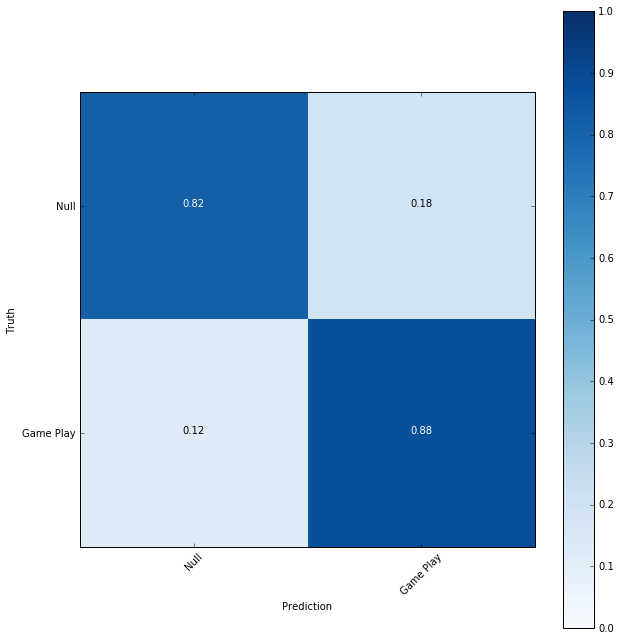

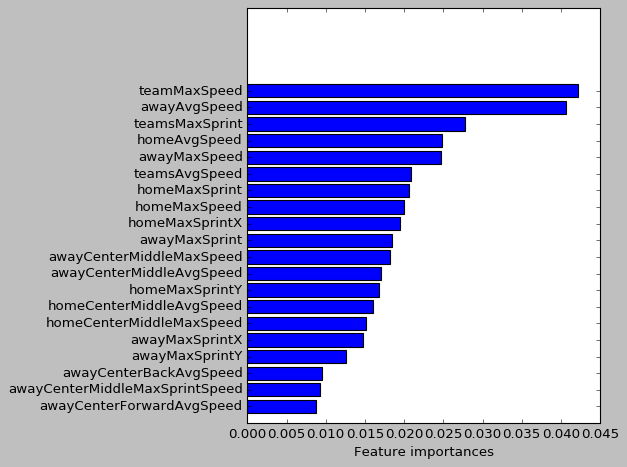

In [36]:
# plot
plot_confusion_matrix(conf_mat, classes, 'Prediction', 'Truth', normalize=True)
plot_hbar_nameval(feature_names, feature_importances, 'Feature importances', max_bars=20)

Overall accuracy: 85%